In [1]:
# !pip install fastai
!pip install -U pyarrow

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import ast
import os
import gc
import matplotlib.pyplot as plt

# from fastai.vision import *

Requirement already up-to-date: pyarrow in /usr/local/lib/python3.6/dist-packages (0.13.0)


In [0]:
# Will need to login to access the bucket. The following lines of code do just that
from google.colab import auth
auth.authenticate_user()

# List out all the files in the directory (Make sure that we are logged in)
gs_path = 'platform-ai-research/datasets/ProductNet/'
# !gsutil ls gs://{gs_path}

In [3]:
# Pull from GS
gs_path = 'platform-ai-research/datasets/ProductNet/'
file_name = 'labels_5m'

remote_file = gs_path + file_name
!gsutil cp gs://{remote_file} {file_name} 

Copying gs://platform-ai-research/datasets/ProductNet/labels_5m...
/ [1 files][202.9 MiB/202.9 MiB]                                                
Operation completed over 1 objects/202.9 MiB.                                    


In [0]:
df = pd.read_feather('labels_5m')

In [5]:
df.head()

,asin,label
0,0000037214,Clothing Accessories
1,0000032069,Clothing
2,0000031909,Athletics
3,0000032034,Clothing
4,0000031852,Athletics


In [6]:
val_cnt = pd.DataFrame(df['label'].value_counts(sort=True)).reset_index()

val_cnt.head()

,index,label
0,Clothing Accessories,1126894
1,Electronics Accessories,425398
2,Vehicle Parts & Accessories,278705
3,"Handbags, Wallets & Cases",259496
4,Clothing,236994


In [0]:
REMOVE_N_LESS_THAN = 125

remove = val_cnt[val_cnt['label'] < REMOVE_N_LESS_THAN]['index'].tolist()

In [8]:
remove

['Small Engines',
 'Live Animals',
 'Finance & Insurance',
 'Erotic',
 'Mining & Quarrying',
 'Shipping Supplies',
 'Heavy Machinery',
 'Magazines & Newspapers',
 'Presentation Supplies',
 'Fanny Packs',
 'Religious Items',
 'Plants',
 'Ottomans',
 'Briefcases',
 'Vehicles']

In [0]:
df = df[~df['label'].isin(remove)]

In [10]:
df['label'].nunique()

142

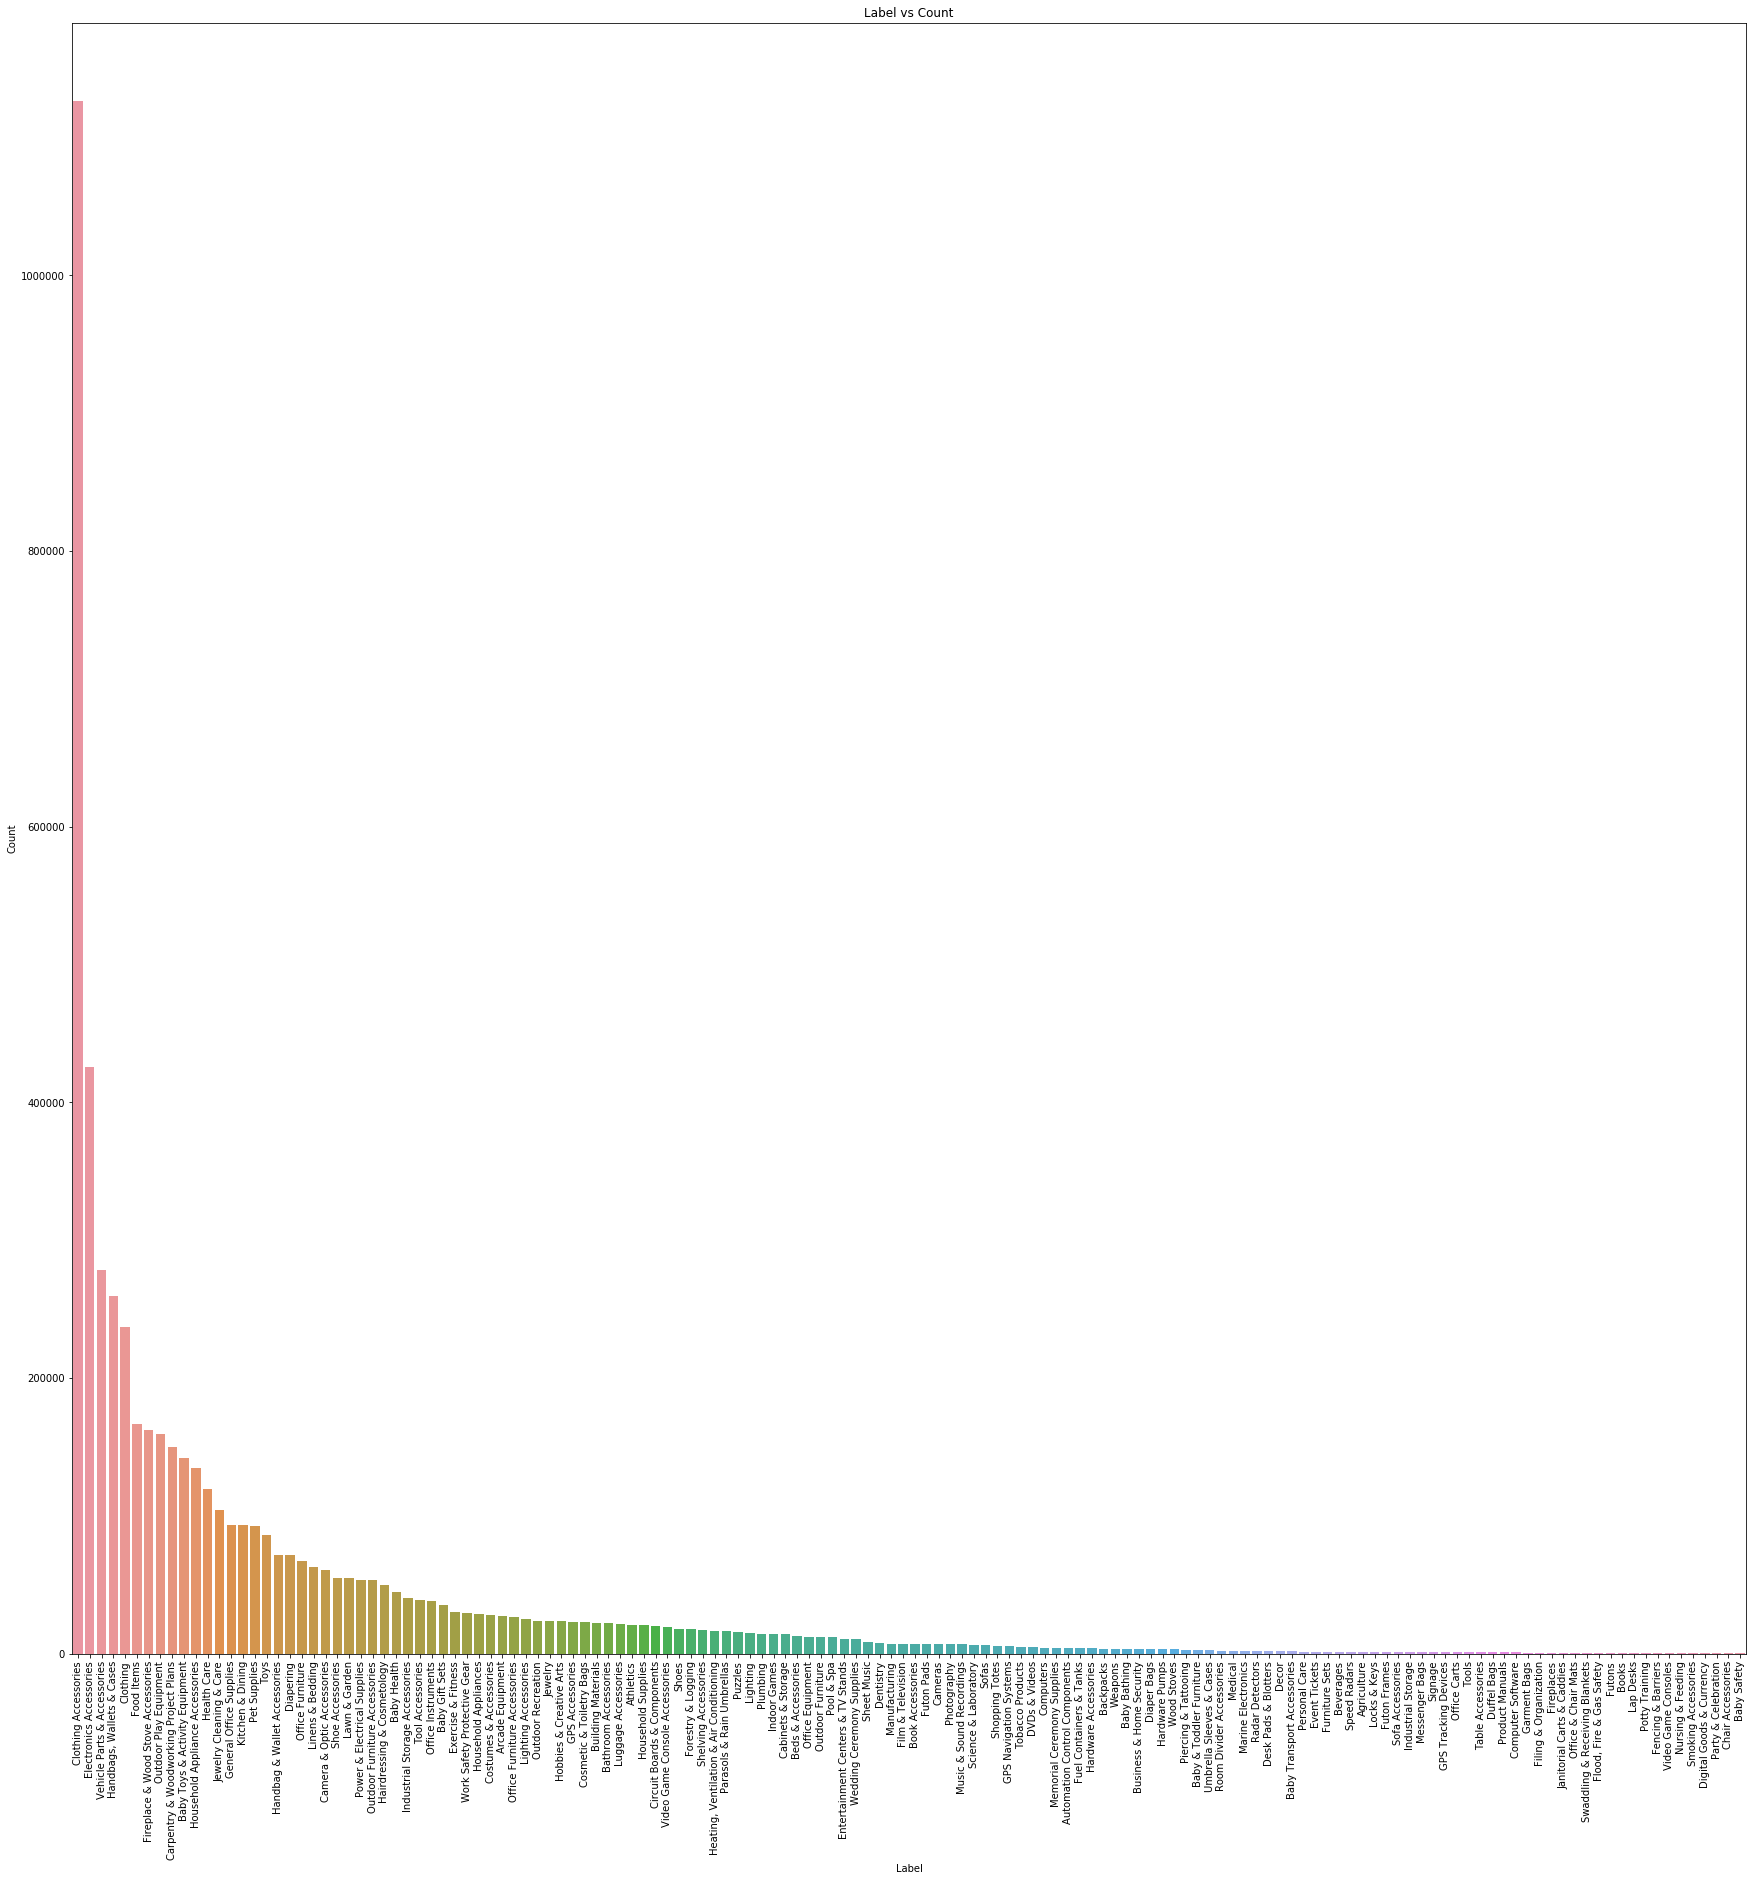

In [11]:
val_cnt = df['label'].value_counts(sort=True)

plt.figure(figsize=(30,30))
sns.barplot(val_cnt.index, 
            val_cnt.values)

plt.xlabel('Label')
plt.xticks(range(len(val_cnt)), val_cnt.index, rotation='vertical')
plt.ylabel('Count')
plt.title('Label vs Count')
plt.show()

In [0]:
val_cnt = pd.DataFrame(val_cnt).reset_index()

val_cnt = val_cnt.rename(columns={'index': 'label', 'label': 'count'})

In [13]:
val_cnt.head()

,label,count
0,Clothing Accessories,1126894
1,Electronics Accessories,425398
2,Vehicle Parts & Accessories,278705
3,"Handbags, Wallets & Cases",259496
4,Clothing,236994


In [0]:
val_cnt['weight'] = 1/val_cnt['count']

In [15]:
val_cnt.head()

,label,count,weight
0,Clothing Accessories,1126894,8.873949e-07
1,Electronics Accessories,425398,2.350740e-06
2,Vehicle Parts & Accessories,278705,3.588023e-06
3,"Handbags, Wallets & Cases",259496,3.853624e-06
4,Clothing,236994,4.219516e-06


In [0]:
# labels = val_cnt['label'].tolist()
# weight = val_cnt['weight'].tolist()

# weightage = dict(zip(labels, weight))

weightage = dict(zip(val_cnt['label'], val_cnt['weight']))

df['weight'] = df['label'].map(weightage)

In [17]:
df.head()

,asin,label,weight
0,0000037214,Clothing Accessories,8.873949e-07
1,0000032069,Clothing,4.219516e-06
2,0000031909,Athletics,4.769855e-05
3,0000032034,Clothing,4.219516e-06
4,0000031852,Athletics,4.769855e-05


In [18]:
sum(df['weight'])

141.99999999900328

In [0]:
SAMPLE_SIZE = 20000

df2 = df.sample(n=SAMPLE_SIZE, weights='weight', random_state=42)

In [0]:
df2 = df2[['asin', 'label']].copy()

In [21]:
df2.head()

,asin,label
1716078,B00318CL78,Baby Transport Accessories
5194615,B00G500248,Books
3724773,B008H6V76A,Furniture Sets
2933955,B005OGR3DM,Camera & Optic Accessories
674743,B000QY9LOG,Agriculture


In [22]:
val_cnt = df2['label'].value_counts(sort=True)

val_cnt.head()

DVDs & Videos                    179
Clothing                         167
Vehicle Parts & Accessories      167
Outdoor Furniture Accessories    167
Shoes                            164
Name: label, dtype: int64

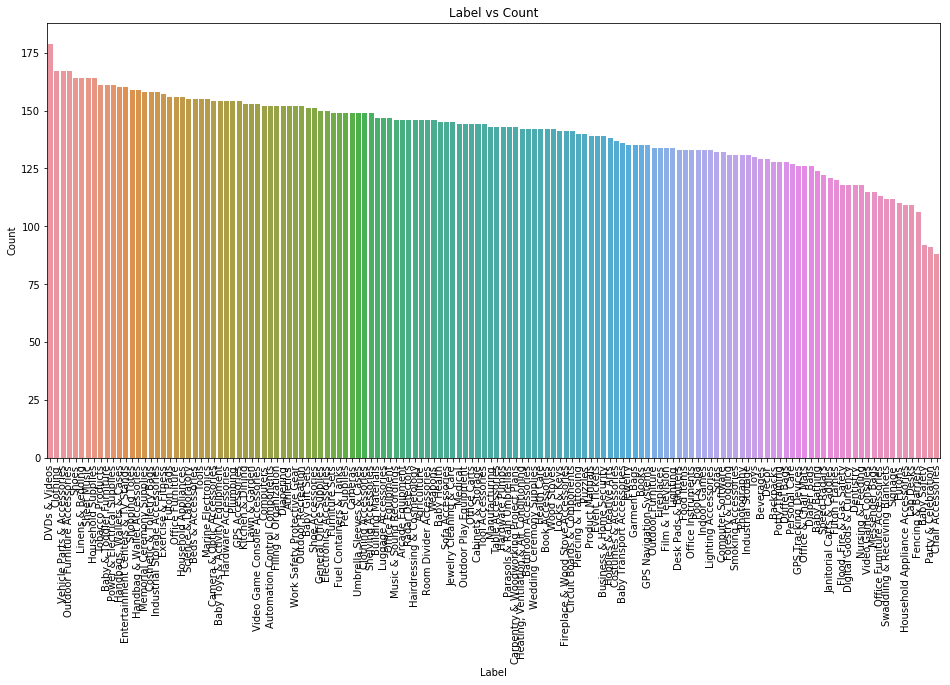

In [26]:
plt.figure(figsize=(16,8))
sns.barplot(val_cnt.index, 
            val_cnt.values)

plt.xlabel('Label')
plt.xticks(range(len(val_cnt)), val_cnt.index, rotation='vertical')
plt.ylabel('Count')
plt.title('Label vs Count')
plt.show()

Merge to get urls, keep only urls, save and push to GS

In [0]:
# # Pull from GS
# gs_path = 'platform-ai-research/datasets/ProductNet/'
# file_name = 'metadata_clean_0513'

# remote_file = gs_path + file_name
# !gsutil cp gs://{remote_file} {file_name} 
  
# # read from metadata
# metadata = pd.read_feather('metadata_clean_0513')

# # merging
# urls = pd.merge(df2, metadata, left_on='asin', right_on='asin', how='inner')

# # keep only url
# urls = urls[['asin', 'imUrl']].copy()

# # check len
# print(len(urls))

# urls.head()

# urls = urls.reset_index(drop=True)

# # save to local
# urls.to_feather('urls_20000')

# # Push to GS
# gs_path = 'platform-ai-research/datasets/ProductNet/'
# file_name = 'urls_20000'

# remote_file = gs_path + file_name
# !gsutil cp {file_name} gs://{remote_file}